# **학습 내용**
2. 텍스트 요약(Text Summarization)
텍스트 요약 방법인 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)에 대해서 알아봅니다.
3. 인공 신경망으로 텍스트 요약 훈련시키기
seq2seq 모델에 대한 개요와 구조 그리고 요소들에 대해서 알아봅니다.
4. 데이터 준비하기
Kaggle에서 제공하는 아마존 리뷰 데이터셋을 다운받고, 데이터를 확인해 봅니다.
5 ~ 7. 데이터 전처리하기
불용어 제거, 정규화, 정수인코딩 등의 데이터 전처리 과정을 코드로 구현합니다.
8. 모델 설계하기
인코더와 디코더, 어텐셔을 설계하고 코드로 구현합니다.
9. 모델 훈련하기
EarlyStopping에 대해서 알아보고, 이를 적용하여 모델을 학습합니다.
10. 인퍼런스 모델 구현하기
정수 인덱스 행렬로 나온 결과값을 실제 데이터로 복원하는 인퍼런스 모델을 코드로 구현합니다.
11. 모델 테스트하기
모델을 통해 얻은 요약문과 실제 요약문을 비교해 봅니다.
12. 추출적 요약 해보기
summa 패키지를 사용하여 추출적 요약(Extractive Summarization)을 해봅니다.


# **학습 목표**
- Extractive/Abstractive summarization 이해할 수 있습니다.
- 단어장 크기를 줄이는 다양한 text normalization 적용할 수 있습니다.
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용할 수 있습니다.

# 1. 데이터 및 패키지 로드
Kaggle에서 제공된 `아마존 리뷰 데이터셋`을 사용  
https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip
!unzip Reviews.csv.zip

--2025-10-28 03:17:26--  https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.170.152.88, 3.170.152.52, 3.170.152.18, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.170.152.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120062355 (114M) [application/zip]
Saving to: ‘Reviews.csv.zip’

Reviews.csv.zip     100%[===================>] 114.50M  22.0MB/s    in 6.3s    

2025-10-28 03:17:33 (18.1 MB/s) - ‘Reviews.csv.zip’ saved [120062355/120062355]

Archive:  Reviews.csv.zip
  inflating: Reviews.csv             


이번 실습은 nltk의 불용어를 사용할 것이다.

In [2]:
!pip install nltk

문서를 parsing하는 BeatifulSoup 라이브러리도 설치

In [3]:
!pip install beautifulsoup4

In [76]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import torch
from collections import Counter

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

data = pd.read_csv("/content/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


전체 샘플수 : 100000


In [77]:
# 데이터의 Summary 열과 Text 열만 학습에 사용할 것이므로 두 개의 열만 저장
data = data[['Text', 'Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
72334,"It's lightly sweet, stays crunchy in milk, and...",My Favorite Cereal
22866,"Tasty and Satisfying, these ostrich meat proti...",Meat of Ostrich Rules!
39572,I didn't realize there was sugar in the Stevia...,Why add sugar to Stevia?
57103,I looked everywhere for Pomegranate Jelly with...,Great Jelly
87923,I think the packaging is ingenious -- who woul...,my pets LOVE this -- great treat !
39134,Pros:<br /> No fishy smell.<br /> More fish ...,Cat Food anyone?
6257,when ordering in bulk with the repeat shipping...,great value
20664,we ordered 3 types of tully's coffee & find th...,k-pods
43526,"This product was delivered on time, but I can ...",Not the best in the World
81771,This item seems like a great idea...a convenie...,Rich bacon smell


Text 열을 요약한 것이 Summary 열.  
이제부터 진행할 것은 Text 시퀀스를 입력받으면 Summary 시퀀스를 예측하도록 모델을 학습시킬 것.

# 2. 데이터 전처리

## 2.1. 중복 데이터 & 결측치 처리

In [78]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


Summary 열이 중복이 되는 경우는 아주 간단한 요약들이 있기 때문에 괜찮지만, Text 중복은 제거해야 한다.

In [79]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [80]:
# null 존재 확인
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [81]:
# 하나 있으므로 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


## 2.2. 텍스트 정규화 & 불용어 제거
정규화 사전 출처:  
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [82]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [83]:
# 불용어 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

NLTK를 이용해 불용어를 제거하는 파트는 Text 전처리에서만 사용할 것이다.  
Summary에는 불용어가 남아 있어야 자연스러운 문장이 되기 때문이다.

In [84]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"', '', sentence) # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [85]:
# 전처리 전/후 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


모두 소문자로 변환, html 태그, 특수문자 제거 등 전처리가 잘 진행되는 것을 확인했으니,  
이제 학습 데이터 전체에 대해 전처리를 수행하자.

In [27]:
clean_text = []

for sentence in data['Text']:
    clean_text.append(preprocess_sentence(sentence))

clean_summary = []

for sentence in data['Summary']:
    clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False))

print("Text 전처리 후 결과: ", clean_text[:5])
print("Summary 전처리 후 결과: ", clean_summary[:5])

/tmp/ipython-input-1353394821.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...> 등의 html 태그 제거


Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']
Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


전처리 후 모든 텍스트가 사라졌는지 확인

In [86]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

,0
Text,0
Summary,70


In [87]:
# 빈 샘플들 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


# 3. train, test 데이터 나누기
학습에 사용할 데이터의 크기를 정하고, 문장의 시작과 끝을 표시해 준다.

## 3.1. 샘플의 최대 길이 지정

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


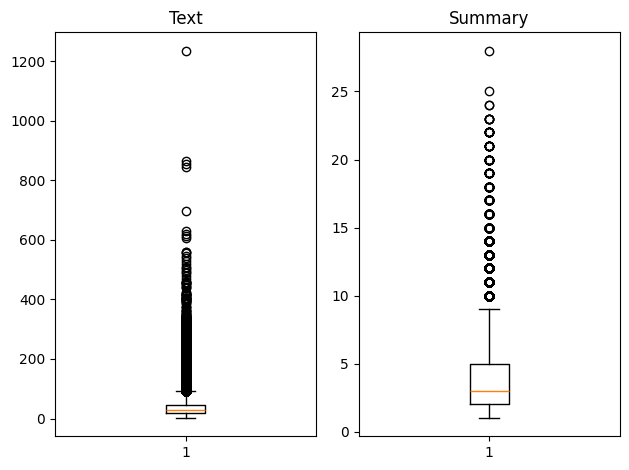

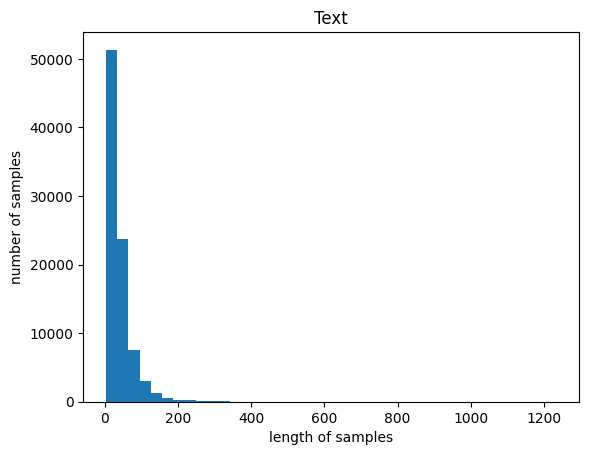

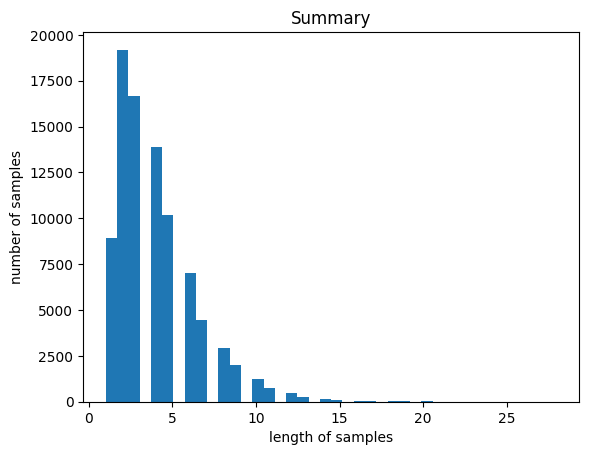

In [88]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [89]:
# 두 열의 최대 길이를 임의로 정해보면
text_max_len = 50
summary_max_len = 8

In [90]:
# 위의 길이로 잘리는 샘플이 총 데이터의 몇 %에 해당하는지 계산해보자
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


text 열의 경우 약 23%의 샘플이 잘리게 된다.  
이번 실습은 정해진 길이에 맞춰 자르는 게 아니라, 정해진 길이보다 길면 제외하는 방법으로 해보자.

In [91]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


## 3.2. 시작/종료 토큰 추가

In [92]:
# 요약 데이터에는 시작/종료 토큰 추가
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [93]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 넘파이 타입으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 3.3. train, test 분리
직접 구현해보자

In [94]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# indices를 이용해 순서 다시 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 테스트 데이터셋 크기 정의
n_of_val = int(len(encoder_input)*0.2)

# 데이터셋 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


# 4. 정수 인코딩

## 4.1. vocab 만들기 및 정수 인코딩

In [103]:
# vocab 만들기
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다.  
그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외할 것.

In [104]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['Text'].tolist()
summary_data = data['Summary'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 35610
등장 빈도가 6번 이하인 희귀 단어의 수: 26409
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9201
단어 집합에서 희귀 단어의 비율: 74.16175231676495
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.988036889250968


vocab에서 희귀 단어의 비율은 74%지만 전체 데이터에서의 비율은 3% 뿐이다.  
vocab의 크기를 9000으로 제한하고 희귀 단어들은 삭제.

In [105]:
src_vocab_size = 9000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [106]:
# 생성된 vocab에 기반하여 input text의 단어들을 모두 정수로 변환하는 인코딩 수행
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[152, 13, 3, 188, 3175, 157, 54, 7], [789, 2773, 13, 313, 3290, 155, 1052, 156, 344, 2057, 512, 176, 262, 2, 656, 599, 5073, 148, 209, 896, 592, 2363], [51, 56, 168, 135, 266, 388, 56, 161, 556, 15, 1796, 3291, 20, 592, 19, 3901, 236, 110, 711, 62, 16, 5, 13, 1295, 78, 1282, 227, 4380, 774, 31, 24, 573]]
[[419, 50, 229, 6, 80, 108, 10, 630, 667, 1984, 37], [2735, 547, 2077, 193, 967, 3678, 708, 53, 982, 1928, 439, 1, 1, 1, 12, 731, 2672, 758, 695, 248, 12, 16, 758, 695, 77, 135, 11, 45, 308, 1, 12, 731, 2672, 758, 695, 248, 12, 763, 1115, 402, 1687], [51, 25, 1477, 1148, 1190, 173, 2147, 2089, 114, 934, 1, 19, 13, 2, 269, 196, 893, 85, 179, 41, 2, 820, 1127, 114, 41, 395, 2, 5458, 269, 196, 3, 433, 185, 2291, 185, 450, 131, 28, 149]]


In [107]:
# summary도 동일하게 수행

def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10472
등장 빈도가 5번 이하인 희귀 단어의 수: 8096
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2376
단어 집합에서 희귀 단어의 비율: 77.31092436974791
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.8817443484558485


In [108]:
tar_vocab_size = 2300
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 4], [2, 1, 1067], [2, 398, 208], [2, 31, 12], [2, 6, 296, 76, 686]]
target
decoder  [[4, 3], [1, 1067, 3], [398, 208, 3], [31, 12, 3], [6, 296, 76, 686, 3]]


이제 인코딩은 완료했고, 패딩 해야한다.  
근데 위에서 빈도수 낮은 단어를 삭제했는데, 그럼 이 삭제된 단어들로만 이루어진 샘플들은 빈 칸이 되었을 것이다.  
특히 평균길이가 4밖에 안 되는 summary는 많이 비어있을 수도 있다.  
확인해보자.  

다만, 위에서 decoder_input에는 sos, decoder_target에는 eos 토큰이 추가된 상태이고, 얘네는 빈도수가 매우 많으므로 삭제되지 않고 남아있을 것이다.
즉, decoder_input에는 sos, decoder_target에는 eos만 남아있을 것.  

그래서 실제로는 summary에 빈 샘플이 없고 길이가 1일 것이다.  


In [111]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


라고 생각해서 실행했는데, 0개가 나옴.  
계속 문제를 찾아봤지만 해결을 못 함.  
결국 직접 토큰을 찾아서 있으면 삭제하는 방법으로 해보자 했는데, 밑의 출력결과를 보면 이것도 안 됨.  
그냥 넘기자

In [113]:
# --- 1. 'sostoken' 또는 'eostoken'만 남은 샘플의 인덱스를 찾습니다 ---
# ( .strip()은 앞뒤 공백을 제거합니다 )

# 1-1. 훈련 데이터 확인
drop_train_indices = set()
for index, sentence in enumerate(decoder_input_train):
    # decoder_input이 'sostoken'만 남은 경우
    if sentence.strip() == 'sostoken':
        drop_train_indices.add(index)

for index, sentence in enumerate(decoder_target_train):
    # decoder_target이 'eostoken'만 남은 경우
    if sentence.strip() == 'eostoken':
        drop_train_indices.add(index)

for index, sentence in enumerate(encoder_input_train):
    # encoder_input(원본 Text)이 비어있는 경우
    if not sentence.strip(): # if sentence.strip() == ""
        drop_train_indices.add(index)

# 1-2. 테스트 데이터 확인
drop_test_indices = set()
for index, sentence in enumerate(decoder_input_test):
    # decoder_input이 'sostoken'만 남은 경우
    if sentence.strip() == 'sostoken':
        drop_test_indices.add(index)

for index, sentence in enumerate(decoder_target_test):
    # decoder_target이 'eostoken'만 남은 경우
    if sentence.strip() == 'eostoken':
        drop_test_indices.add(index)

for index, sentence in enumerate(encoder_input_test):
    # encoder_input(원본 Text)이 비어있는 경우
    if not sentence.strip():
        drop_test_indices.add(index)


# --- 2. 원본 코드의 나머지 부분 (필터링) ---
print('삭제할 훈련 데이터의 개수 :', len(drop_train_indices))
print('삭제할 테스트 데이터의 개수 :', len(drop_test_indices))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train_indices]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train_indices]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train_indices]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test_indices]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test_indices]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test_indices]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


## 4.2. 패딩

In [114]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

# 5. 모델 설계

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)